In [1]:
import argparse
import os
import sys
import time
from collections import defaultdict
from PIL import Image
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import data_loader

import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

# Config

In [2]:
torch.backends.cudnn.benchmark = True

parser = argparse.ArgumentParser()

# Dataset options
parser.add_argument('--loader_num_workers', default=4, type=int)
parser.add_argument('--obs_len', default=20, type=int)
parser.add_argument('--pred_len', default=20, type=int)
parser.add_argument('--step', default=10, type=int)

# Model Options
parser.add_argument('--embedding_dim', default=64, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_norm', action='store_true')
parser.add_argument('--mlp_dim', default=1024, type=int)
parser.add_argument('--encoder_h_dim', default=64, type=int)
parser.add_argument('--decoder_h_dim', default=64, type=int)

# Optimization
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--num_iterations', default=10000, type=int)
parser.add_argument('--num_epochs', default=50, type=int)
parser.add_argument('--learning_rate', default=1e-3, type=float)
parser.add_argument('--grad_max_norm', default=0.25, type=float)

# Output
parser.add_argument('--output_dir', default=os.getcwd())
parser.add_argument('--print_every', default=30, type=int)
parser.add_argument('--checkpoint_every', default=100, type=int)
parser.add_argument('--checkpoint_name', default='checkpoint')
parser.add_argument('--checkpoint_start_from', default=None)
parser.add_argument('--restore_from_checkpoint', default=1, type=int)
parser.add_argument('--num_samples_check', default=5000, type=int)

# Misc
parser.add_argument('--use_gpu', action='store_true')
parser.add_argument('--gpu_id', default="0", type=str)

# A trick to enable arg parsing in ipynb
import sys
sys.argv = 'main.py'
sys.argv = sys.argv.split(' ')
args = parser.parse_args()

os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id 

# Datasets

In [3]:
def plot_seq(ax, img, seq, color, linestyle='-', linewidth=1):                                                           
    '''                                                                                                                 
    Input:                                                                                                              
    - img: reference image                                                                                              
    - seq_ped: np/torch array of shape (traj_len, 2)                                                                    
    '''                                          
    ax.plot(seq[:-1,0], seq[:-1,1], color=color, 
            linewidth=linewidth, linestyle=linestyle)
    ax.arrow(seq[-2,0], seq[-2,1], seq[-1,0]-seq[-2,0], seq[-1,1]-seq[-2,1],
            head_width=2.5, head_length=2, fc=color, ec=color, linewidth=1)

## Train set

In [4]:
train_set, train_loader = data_loader(args, 'train', 'Biker')
iterations_per_epoch = len(train_set) / args.batch_size
if args.num_epochs:
    args.num_iterations = int(iterations_per_epoch * args.num_epochs)

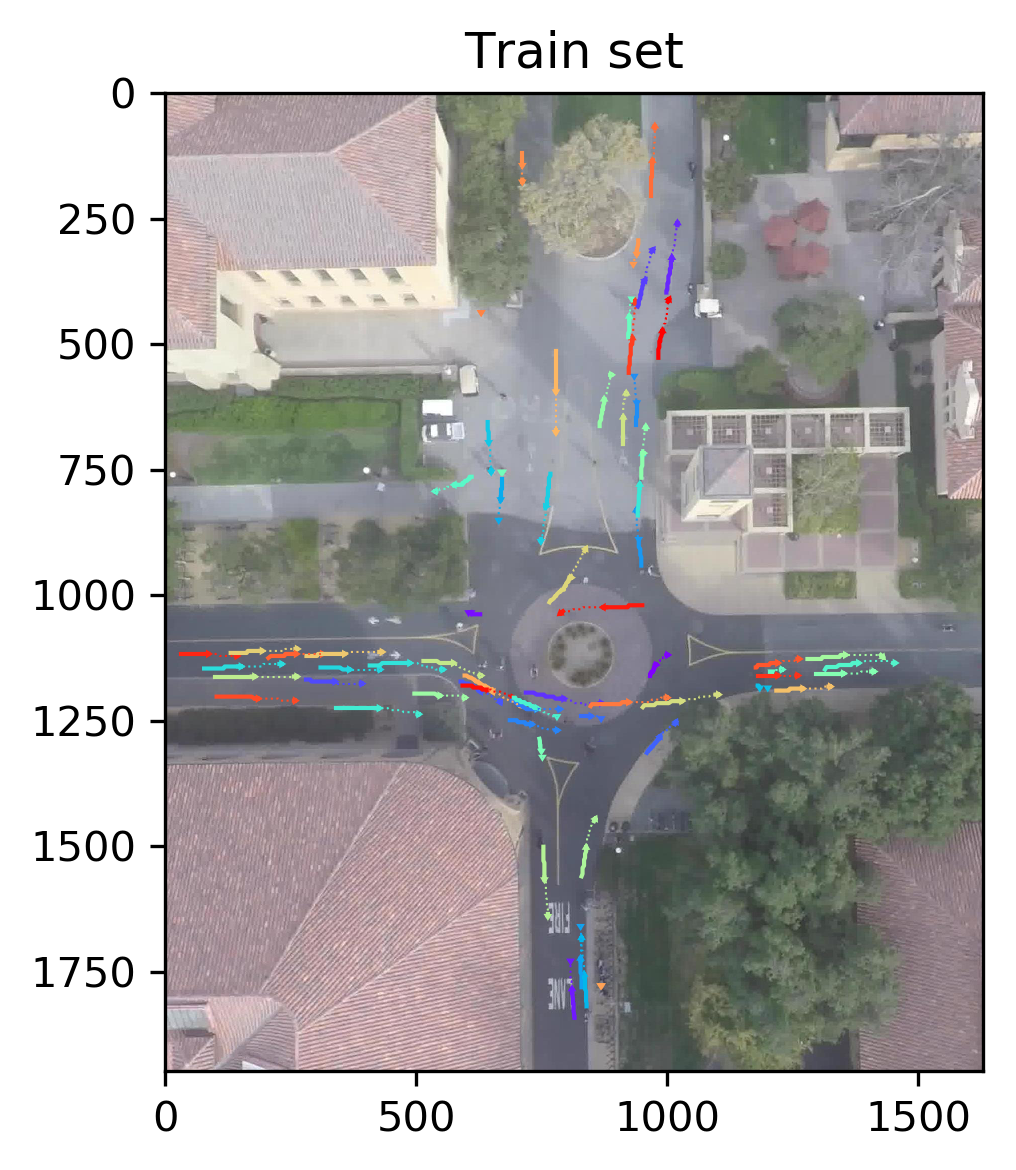

In [5]:
width, height = plt.figaspect(1) # 1.68
fig = plt.figure(figsize=(width,height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
colors = iter(cm.rainbow(np.linspace(0, 1, args.batch_size)))

img = np.array(Image.open('reference.jpg'))
batch = next(iter(train_loader))

xy_max = train_set.xy_max[np.newaxis, np.newaxis, :]
obs_seq_list, pred_seq_list = batch[0], batch[1]
obs_seq_list = obs_seq_list.numpy() * xy_max
pred_seq_list = pred_seq_list.numpy() * xy_max

ax.imshow(img)

for seq, pred in zip(obs_seq_list.transpose((1,0,2)), 
                     pred_seq_list.transpose((1,0,2))):
    color = next(colors)
    plot_seq(ax, img, seq, color=color)
    plot_seq(ax, img, pred, color=color, linestyle=':', linewidth=0.5)
    
plt.title('Train set')
plt.tight_layout()

## Val set

In [6]:
val_set, val_loader = data_loader(args, 'val', 'Biker')

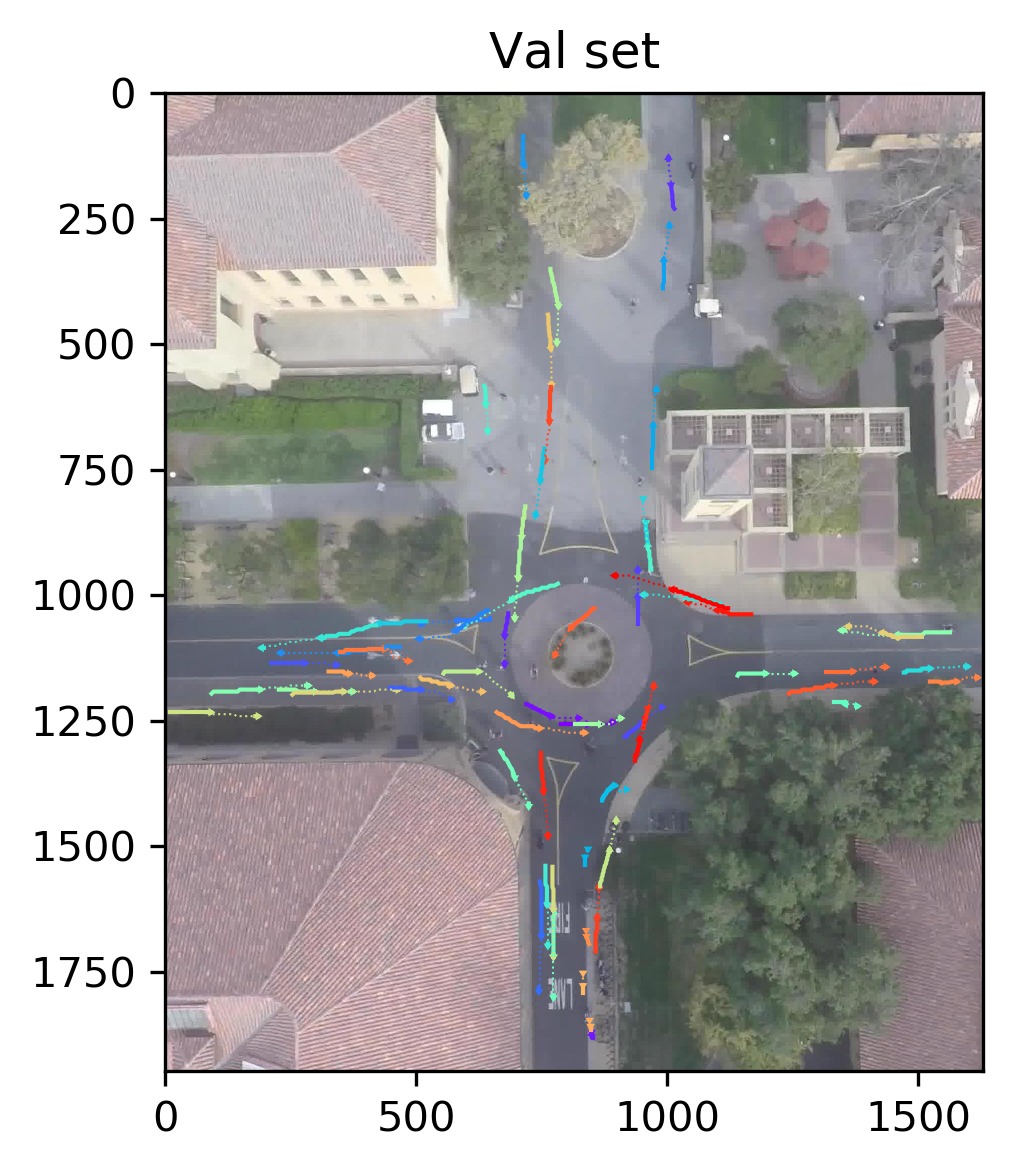

In [7]:
width, height = plt.figaspect(1) # 1.68
fig = plt.figure(figsize=(width,height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
colors = iter(cm.rainbow(np.linspace(0, 1, args.batch_size)))

img = np.array(Image.open('reference.jpg'))
batch = next(iter(val_loader))

xy_max = train_set.xy_max[np.newaxis, np.newaxis, :]
obs_seq_list, pred_seq_list = batch[0], batch[1]
obs_seq_list = obs_seq_list.numpy() * xy_max
pred_seq_list = pred_seq_list.numpy() * xy_max

ax.imshow(img)

for seq, pred in zip(obs_seq_list.transpose((1,0,2)), 
                     pred_seq_list.transpose((1,0,2))):
    color = next(colors)
    plot_seq(ax, img, seq, color=color)
    plot_seq(ax, img, pred, color=color, linestyle=':', linewidth=0.5)
    
plt.title('Val set')
plt.tight_layout()

# Training

In [8]:
from main import main

predictor, checkpoint = main(args, train_loader, val_loader)

Epoch 1, Iter 225 / 11250: losses[ade-batch] = 0.9759: 100%|██████████| 225/225 [00:26<00:00, 10.20it/s]
Epoch 2, Iter 450 / 11250: losses[ade-batch] = 0.9348: 100%|██████████| 225/225 [00:25<00:00, 11.41it/s]
Epoch 3, Iter 675 / 11250: losses[ade-batch] = 1.4639: 100%|██████████| 225/225 [00:25<00:00,  8.71it/s]
Epoch 4, Iter 900 / 11250: losses[ade-batch] = 0.9136: 100%|██████████| 225/225 [00:25<00:00,  8.71it/s]
Epoch 5, Iter 1125 / 11250: losses[ade-batch] = 0.8776: 100%|██████████| 225/225 [00:28<00:00,  7.79it/s]
Epoch 6, Iter 1350 / 11250: losses[ade-batch] = 0.8912: 100%|██████████| 225/225 [00:26<00:00, 11.28it/s]
Epoch 7, Iter 1575 / 11250: losses[ade-batch] = 0.7524: 100%|██████████| 225/225 [00:26<00:00,  8.46it/s]
Epoch 8, Iter 1800 / 11250: losses[ade-batch] = 0.9058: 100%|██████████| 225/225 [00:26<00:00, 10.79it/s]
Epoch 9, Iter 2025 / 11250: losses[ade-batch] = 0.7873: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]
Epoch 10, Iter 2250 / 11250: losses[ade-batch] = 0

=====> Terminate training at epoch 50 iteration 11251


# Quantitative evaluation

# Qualitative evaluation

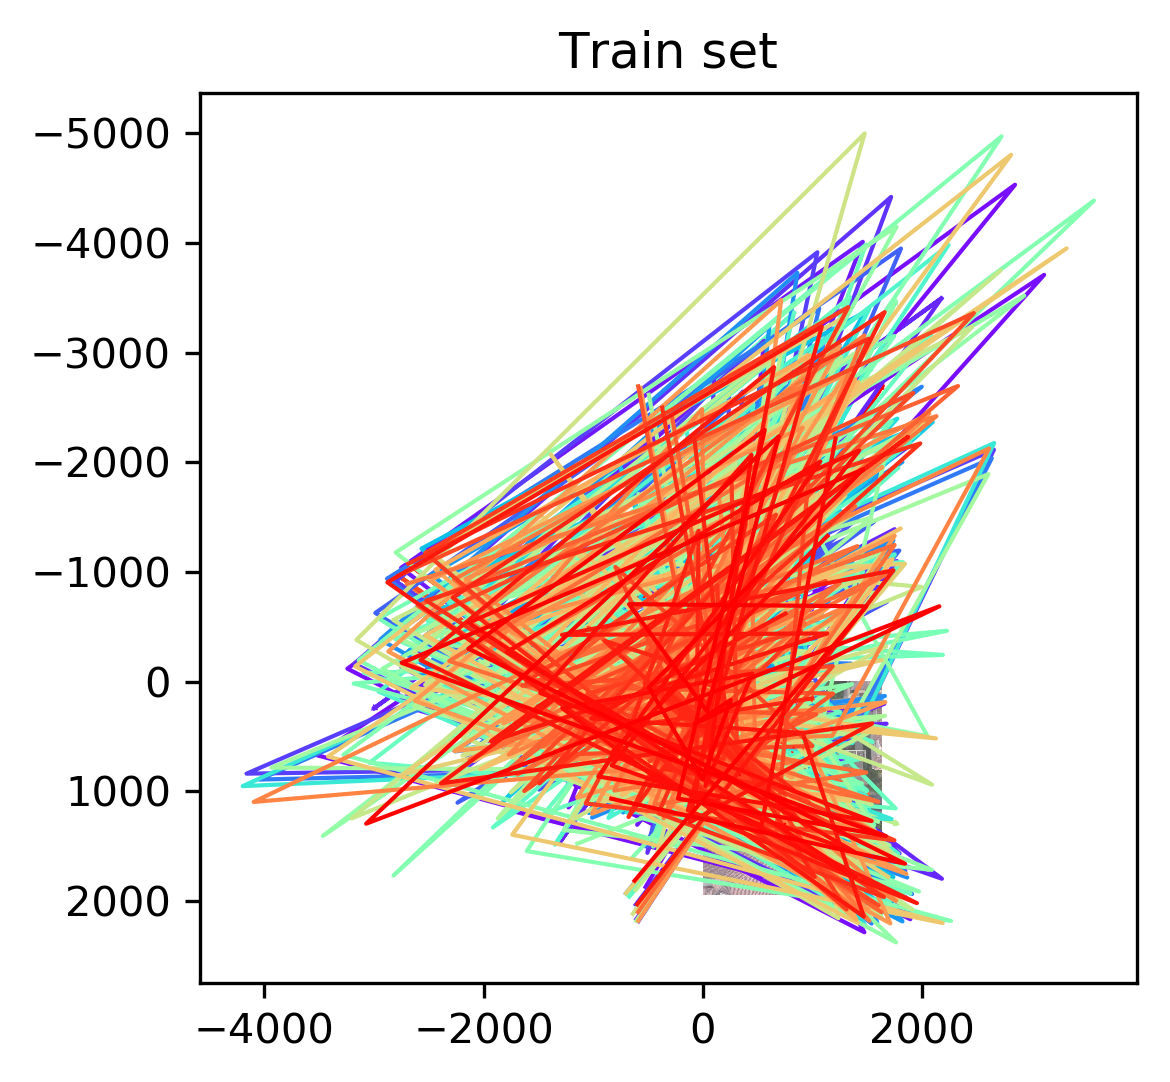

In [9]:
width, height = plt.figaspect(1) # 1.68
fig = plt.figure(figsize=(width,height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
colors = iter(cm.rainbow(np.linspace(0, 1, args.batch_size)))

img = np.array(Image.open('reference.jpg'))
batch = next(iter(train_loader))

xy_max = train_set.xy_max[np.newaxis, np.newaxis, :]

(obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, obs_msk, pred_msk) = batch

pred_traj_fake = predictor(obs_traj)

pred_traj_fake = pred_traj_fake.detach().numpy() * xy_max
pred_traj_gt = pred_traj_gt.numpy() * xy_max

ax.imshow(img)

for fake, gt in zip(pred_traj_fake.transpose((1,0,2)), 
                     pred_traj_gt.transpose((1,0,2))):
    color = next(colors)
    plot_seq(ax, img, fake, color=color)
    plot_seq(ax, img, gt, color=color, linestyle=':', linewidth=0.5)
    
plt.title('Train set')
plt.tight_layout()